# How to merge our time series?

## Time between consecutive data points

So far we have 3 data sources:
* **Cbtool data** (`VM_runtime_app_*.csv`)
* **CPU+Memory** (`metric_node_baati_cpu.csv`, `metric_node_baati_memory.csv`)
* **OS metrics** (`metric_os.csv`)

We need to check what are the time differences between consecutive data points to be able to merge those sources reasonably.

We'll use data from `linpack_12x20` experiment.

In [1]:
from collections import defaultdict

import pandas as pd

from helpers.load_data import (
    get_cbtool_data,
    get_cpu_data,
    get_experiments_paths,
    get_mem_data,
    get_os_metrics,
)


def count_time_diffs(df: pd.DataFrame):
    res = defaultdict(int)

    for i in range(1, len(df)):
        diff = df['time'].iloc[i] - df['time'].iloc[i - 1]
        res[diff] += 1

    return res


def print_time_diffs(diff_count: dict):
    print('Differences between consecutive data points:')
    
    diff_sum = 0
    number = 0
    
    for diff, count in sorted(diff_count.items()):
        print(f'{diff} seconds: {count} times')
        diff_sum += diff * count
        number += count
    
    print(f'Average time diff: {diff_sum / number:.4f}')
        

experiments_path = '../../data'
experiment_name = 'linpack_1_linpack_11'
path = list(get_experiments_paths(experiment_name, experiments_path))[0]

### Cbtool data

In [2]:
df_cbt = get_cbtool_data(path, instances_n=12)
diff_count = count_time_diffs(df_cbt)
print_time_diffs(diff_count)

Differences between consecutive data points:
83 seconds: 3 times
84 seconds: 5 times
85 seconds: 4 times
86 seconds: 1 times
87 seconds: 1 times
88 seconds: 1 times
89 seconds: 16 times
90 seconds: 21 times
91 seconds: 6 times
92 seconds: 8 times
94 seconds: 1 times
95 seconds: 5 times
96 seconds: 6 times
97 seconds: 2 times
98 seconds: 2 times
101 seconds: 1 times
108 seconds: 1 times
109 seconds: 1 times
110 seconds: 1 times
111 seconds: 1 times
115 seconds: 1 times
118 seconds: 2 times
129 seconds: 2 times
139 seconds: 1 times
143 seconds: 1 times
144 seconds: 1 times
148 seconds: 1 times
159 seconds: 1 times
167 seconds: 1 times
171 seconds: 1 times
175 seconds: 1 times
179 seconds: 1 times
180 seconds: 2 times
181 seconds: 3 times
182 seconds: 1 times
183 seconds: 1 times
187 seconds: 2 times
188 seconds: 1 times
189 seconds: 1 times
190 seconds: 1 times
191 seconds: 1 times
192 seconds: 1 times
193 seconds: 1 times
194 seconds: 1 times
199 seconds: 1 times
201 seconds: 2 times
20

The tests are run sequentially. We can see that initially, when there is only one instance on the machine, the completion time is around `52` seconds.  When more instances are added, the completion time lengthens to even `238` seconds.

### CPU / Memory

In [3]:
df_cpu = get_cpu_data(path)
diff_count = count_time_diffs(df_cpu)
print_time_diffs(diff_count)

Differences between consecutive data points:
10 seconds: 532 times
11 seconds: 22 times
20 seconds: 508 times
21 seconds: 35 times
30 seconds: 6 times
31 seconds: 2 times
Average time diff: 15.1122


From the field `windowSeconds` we know that each CPU/memory value is averaged from the last `30` seconds.

We can see that these metrics gathered mostly every `10` or `20` seconds.

### OS metrics

In [4]:
df_os = get_os_metrics(path)
diff_count = count_time_diffs(df_os)
print_time_diffs(diff_count)

Differences between consecutive data points:
1 seconds: 753 times
2 seconds: 78 times
3 seconds: 63 times
4 seconds: 480 times
5 seconds: 2536 times
6 seconds: 166 times
Average time diff: 4.0957


On the other hand, OS metrics are gathered more regularly - the frequency is `~5s` with some small delays.

In [5]:
a = list(df_os.columns)
[x for x in a if 'mem' in x]
len(a)

1952

## Emerging problems

#### **1. Our dataseries have different frequencies and semantics.**
* Cbtool `app_latency` and `app_throughput` is an average from a single workload. The completion time of the workload varies with time (depends on the performance of the machine).

* CPU/memory metrics are averages from last `30s` and have alternating frequency (lower than `30s`).

* OS metrics are measurements in a given time, but the semantic depends on the metrics class. More info at: https://github.com/prometheus/node_exporter#enabled-by-default

#### **2. New instance can be running for a while without any trace in cbtool metrics.**
Imagine a situation, in which completion time of the workload is initially 50s. One instance is running and then we add a second instance at time `T`. If we take first metric of the second instance (time `T+50`) as a point dividing `instances_n=1` and `instances_n=2`, then we have 50 seconds of two instances running while `instances_n=1`, so we need to take that into account.

## Solution

### How to merge Cbtool metrics with CPU/memory metrics?

Cbtool metrics are the rarest, so for every Cbtool metric, we want to select and average CPU metrics that correspond CPU load during running the workload run. We have cbtool windows (50-300s) and CPU windows (30s) every 10/20s that overlap, so multiple CPU windows can fit into one Cbtool window.

If we average overlapping windows, it will work like a weighted average.

If we select only one CPU window within Cbtool window, then it will only represent a part of the experiment.

Another idea is to take as many non-overlapping CPU windows as we can and average them.

### How to merge Cbtool metrics with OS metrics?

We just take all OS metrics fitting into Cbtool window and average them.

## Implementation

Let's see how new implementation compares to the old one.

In [6]:
from helpers.load_data import (
    get_data_with_metrics,
    get_data_with_metrics_old,
    trim_experiment,
)
from helpers.regression import (
    draw_regression_graph,
    fit_regression,
)


experiments_path = '../../data'
experiment_name = 'linpack_12x20'
path = next(get_experiments_paths(experiment_name, experiments_path))
df1 = get_data_with_metrics_old(path, instances_n=12, max_time_diff=5)
df1 = trim_experiment(df1, 6)
df2 = get_data_with_metrics(path, instances_n=12, cpu_window=30)
df2 = trim_experiment(df2, 6)

StopIteration: 

### Old - `cpu ~ instances_n`

In [ ]:
results = fit_regression(data=df1, formula='cpu ~ instances_n')
draw_regression_graph(results, df1, metric_name='cpu', variable='instances_n')
print(results.summary())

### New - `cpu ~ instances_n`

In [ ]:
results = fit_regression(data=df2, formula='cpu ~ instances_n')
draw_regression_graph(results, df2, metric_name='cpu', variable='instances_n')
print(results.summary())

### Old - `app_throughput ~ instances_n`

In [ ]:
results = fit_regression(data=df1, formula='app_throughput ~ instances_n')
draw_regression_graph(results, df1, metric_name='app_throughput', variable='instances_n')
print(results.summary())

### New - `app_throughput ~ instances_n`

In [ ]:
results = fit_regression(data=df2, formula='app_throughput ~ instances_n')
draw_regression_graph(results, df2, metric_name='app_throughput', variable='instances_n')
print(results.summary())

### Old - `app_throughput ~ cpu`

In [ ]:
results = fit_regression(data=df1, formula='app_throughput ~ cpu')
draw_regression_graph(results, df1, metric_name='app_throughput', variable='cpu')
print(results.summary())

### New - `app_throughput ~ cpu`

In [ ]:
results = fit_regression(data=df2, formula='app_throughput ~ cpu')
draw_regression_graph(results, df2, metric_name='app_throughput', variable='cpu')
print(results.summary())

### CBTOOL metric interval coverage

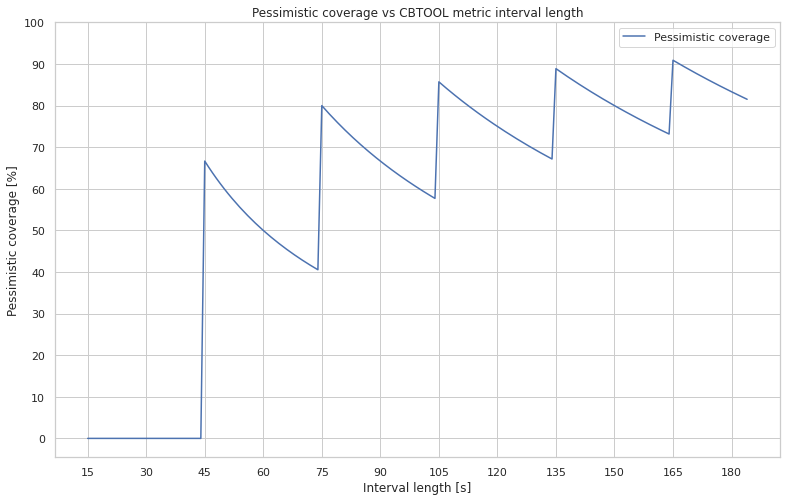

In [9]:
import matplotlib.pyplot as plt

def coverage_pessimistic(x: int) -> float:
    return ((x - 15) // 30) * 30 / x * 100

def coverage_optimistic(x: int) -> float:
    return x // 30 * 30 / x * 100

xs = list(range(15, 185, 1))
ys = [coverage_pessimistic(x) for x in xs]
ys2 = [coverage_optimistic(x) for x in xs]
df_cov = pd.DataFrame({'interval_length': xs, 'Pessimistic coverage': ys, 'Optimistic coverage': ys2})
ax = df_cov.plot(x='interval_length', y=['Pessimistic coverage'], figsize=(13,8))
ax.set_xlabel('Interval length [s]')
ax.set_ylabel('Pessimistic coverage [%]')
ax.set_title('Pessimistic coverage vs CBTOOL metric interval length')
ax.set_xticks(range(15, 190, 15))
ax.set_yticks(range(0, 101, 10))
ax.legend(loc='best')
plt.savefig('coverage.png')

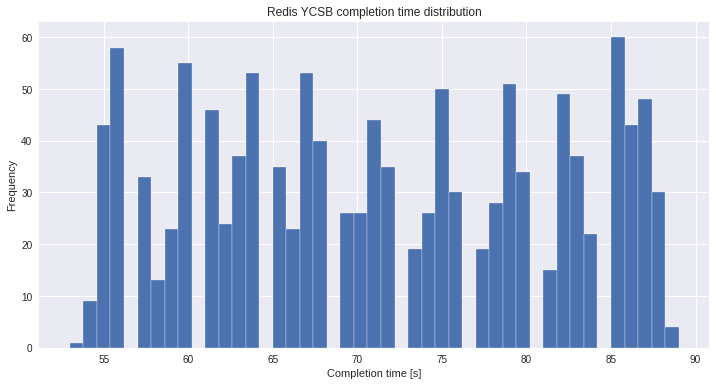

In [88]:
experiments_path = '../../data'
experiment_name = 'redis_ycsb_d_1_redis_ycsb_d_9'

diff_count = defaultdict(int)

df_cbt = pd.DataFrame()
for path in list(get_experiments_paths(experiment_name, experiments_path))[:]:
    df_cbt = df_cbt.append(get_cbtool_data(path, instances_n=10))

ax = df_cbt['app_completion_time'].plot.hist(bins=45, figsize=(12,6))
ax.set_xlabel('Completion time [s]')
ax.set_ylabel('Frequency')
ax.set_title('Redis YCSB completion time distribution')
plt.savefig('graphs/redis_ycsb_completion_time_distribution.png')